In [1]:
import torch
from torch import nn 
from d2l import torch as d2l

In [2]:
class Seq2SeqEncoder( nn.Module ):
    '''编码器'''
    def __init__( self ,  vocab_size , embeding_size , num_hiddens , num_layers ,  dropout = 0 ):
        super().__init__()
        self.embed_layer = nn.Embedding( vocab_size , embeding_size )
        self.rnn_layer = nn.GRU( embeding_size , num_hiddens   , num_layers )

    def forward( self  , X , *args ):
        # (`batch_size`, `num_steps`) ---> (`batch_size`, `num_steps`, `embed_size`)
        X = self.embed_layer( X  )
        X = X.permute( 1 , 0 , 2 )
        outputs , state = self.rnn_layer( X )
        return outputs , state

In [3]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError


In [4]:
class Seq2SeqAttentionDecoder( AttentionDecoder ):
    def __init__( self , vocab_size , embed_size , num_hiddens , num_layers  , dropout = 0 , **kwargs ):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        #num_hiddens是每个输入数据的num_hiddens ，我们保证传入的数据最后一个轴都是num_hiddens就行
        #这里的q,k,v最后的轴都是num_hiddens
        self.attention = d2l.AdditiveAttention( num_hiddens , num_hiddens , num_hiddens , dropout  )
        self.embedding = nn.Embedding( vocab_size , embed_size )
        #采用类似Seq2SeqDecoder的结构 , 那么这个rnn算子的接口也是一样的，这里不作过多解释，详情请看Seq2SeqDecoder
        self.rnn = nn.GRU( embed_size + num_hiddens  , num_hiddens , num_layers , dropout = dropout )
        self.dense = nn.Linear( num_hiddens , vocab_size )
    
    def init_state( self , enc_outputs  , enc_valid_lens , *args ):
        #outputs的形状为( num_steps , batch_size ,  num_hiddens )
        #state的形状为( num_layers , batch_size , num_hiddens )
        outputs , hidden_state = enc_outputs#将encoder(X)的输出进行分解得到( 全部时间步的隐藏状态outputs , 最后一个时间步的隐藏状态state )
        return ( outputs.permute( 1 , 0  , 2  ) , hidden_state , enc_valid_lens )
        # outputs(  batch_size , num_steps ,  num_hiddens ) 
    def forward( self , X , state ):
        #enc_outputs的形状为(  batch_size , num_steps ,  num_hiddens ) 
        #state的形状为( num_layers , batch_size , num_hiddens )       
        enc_outputs , hidden_state , enc_valid_lens = state
        #X的形状为( batch_size , num_steps ) 输出X的形状为( num_steps , batch_size , embed_size )
        X = self.embedding( X ).permute( 1 , 0 , 2 )
        outputs , self._attention_weights = [],[]
        for x in X:
            #( batch_size , num_hiddens ) ---> ( batch_size , 1 , num_hiddens )
            queries = torch.unsqueeze( hidden_state[0] , dim=1 )
            #上下文变量就是这个decoder的关键,使用decoder的第t-1个时间步的隐藏状态( query )去
            #与encoder的全部时间步的隐藏状态( keys )进行加性注意力分数打分，之后使用遮蔽softmax得到注意力
            #分布与encoder的全部时间步的隐藏状态( keys )相乘得到注意力汇聚，最终shape为( batch_size , 查询的个数 , 值的维度 )
            # 分析：这种注意力机制就是想看看当前decoder中的传出来的隐藏状态与encoder总体的隐藏状态近似情况。
            # 就是说想看看当前词元的翻译是原语句当中的第几个词元。从当前翻译的词元不断通过注意力机制找到原语句当中
            # 的词元，不断更改上下文变量使上下文变量更加聚焦于当前翻译词元对应原文词元的位置。
            #
            #context的shape( batch_size , 1 , num_hiddens  )
            context = self.attention( queries , enc_outputs , enc_outputs , enc_valid_lens )
            #在特征维度上连结 x --->( batch_size , 1 , embed_size + num_hiddens )
            x = torch.cat( ( context , torch.unsqueeze( x , dim=1 ) ) , dim= -1  )
            # 将 `x` 变形为 (1, `batch_size`, `embed_size` + `num_hiddens`)
            # out --->( 1 , batch_size , num_hiddens  ) hidden_state( num_layers , batch_size , num_hiddens  )
            out , hidden_state = self.rnn( x.permute( 1 , 0 , 2 ) , hidden_state )
            outputs.append( out )
            self._attention_weights.append( self.attention.attention_weights  )
            # 全连接层变换后， `outputs` --cat操作--> ( num_steps , batch_size , num_hiddens  )
            # ---> (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense( torch.cat( outputs , dim= 0 ) )
        return outputs.permute( 1 , 0  , 2 ) , [ enc_outputs , hidden_state , enc_valid_lens ]

    @property
    def attention_weights(self):
        return self._attention_weights

In [5]:
encoder = Seq2SeqEncoder( vocab_size=10 , embeding_size= 8 , num_hiddens= 16 , num_layers= 2 )
encoder.eval()
decoder = Seq2SeqAttentionDecoder( vocab_size=10 , embed_size=8 , num_hiddens= 16 , num_layers= 2 )
decoder.eval()
X = torch.zeros(( 4 , 7 ) , dtype= torch.long )# (`batch_size`, `num_steps`)
state = decoder.init_state( encoder( X ) , None )
output , state = decoder( X , state )
state[0].shape

torch.Size([4, 7, 16])

loss 0.020, 4178.1 tokens/sec on cuda:1


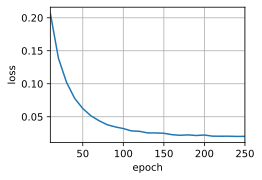

In [7]:
embed_size , num_hiddens , num_layers , dropout = 32 , 32 , 2 , 0.1
batch_size , num_steps = 64 , 10
lr , num_epochs , device = 0.005 , 250 , d2l.try_gpu( i = 1 )

train_iter , src_vocab , tgt_vocab = d2l.load_data_nmt( batch_size , num_steps )
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq( net, train_iter, lr, num_epochs, tgt_vocab, device )